In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dev-achintha/Sri_Lanka-Tourism_Forcasting_Model/working/dataset/2015-2024-monthly-tourist-arrivals-sl-csv.csv')
"""
Reads a CSV file containing monthly tourist arrivals data, processes the data, and returns a cleaned DataFrame.

Steps:
1. Reads the CSV file from the provided URL.
2. Drops the 'PercentageChange' column if it exists.
3. Creates a new datetime column 'ds' by combining 'Year' and 'Month' columns.
4. Renames the 'Arrivals' column to 'y'.
5. Selects only the 'ds' and 'y' columns.
6. Sorts the DataFrame by the 'ds' column.
7. Resets the DataFrame index.

Returns:
    pd.DataFrame: A cleaned DataFrame with columns 'ds' (datetime) and 'y' (tourist arrivals).
"""
df = df.drop(columns=['PercentageChange'], errors='ignore')
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
df.rename(columns={'Arrivals': 'y'}, inplace=True)
df = df[['ds', 'y']]
df.sort_values('ds', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,ds,y
0,2014-01-01,146575
1,2014-02-01,141878
2,2014-03-01,133048
3,2014-04-01,112631
4,2014-05-01,90046


In [3]:
def time_series_cv(model_function, data, initial_train_size, horizon, model_name):
    """
    Perform time series cross-validation.

    Parameters:
    model_function (function): Function to fit and forecast the model. It should accept the training data and the number of periods to forecast as arguments.
    data (pd.DataFrame): The complete dataset containing the time series data. It must have columns 'ds' for dates and 'y' for values.
    initial_train_size (int): Initial number of observations to use as training data.
    horizon (int): Number of periods to forecast in each fold.
    model_name (str): Name of the model (for display purposes).

    Returns:
    pd.DataFrame: A DataFrame with columns 'ds' for dates, 'Actual' for actual values, and 'Predicted' for forecasted values.
    """
    n_records = len(data)
    n_splits = (n_records - initial_train_size) // horizon
    predictions = []
    actuals = []
    dates = []

    for i in range(n_splits):
        train_end = initial_train_size + i * horizon
        test_end = train_end + horizon

        train_data = data.iloc[:train_end]
        test_data = data.iloc[train_end:test_end]

        # Fit and forecast
        y_pred = model_function(train_data.copy(), len(test_data))

        predictions.extend(y_pred)
        actuals.extend(test_data['y'].values)
        dates.extend(test_data['ds'].values)

        print(f"{model_name} - Fold {i+1}/{n_splits} completed.")

    results = pd.DataFrame({'ds': dates, 'Actual': actuals, 'Predicted': predictions})
    return results

In [4]:
def prophet_model(train_data, periods):
    """
    Trains a Prophet model on the provided training data and forecasts future values.

    Parameters:
    train_data (pd.DataFrame): A DataFrame containing the training data with columns 'ds' (date) and 'y' (value).
    periods (int): The number of periods (months) to forecast into the future.

    Returns:
    np.ndarray: An array of forecasted values for the specified number of periods.
    """
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
                    changepoint_prior_scale=0.1, n_changepoints=30)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(train_data)
    future = model.make_future_dataframe(periods=periods, freq='MS')
    forecast = model.predict(future)
    y_pred = forecast[['ds', 'yhat']].tail(periods)['yhat'].values
    return y_pred

In [5]:
def sarima_model(train_data, periods):
    """
    Fits a SARIMA model to the provided training data and forecasts future values.

    Parameters:
    train_data (pd.DataFrame): A DataFrame containing the training data with a column 'y' representing the time series values.
    periods (int): The number of periods to forecast into the future.

    Returns:
    np.ndarray: An array containing the forecasted values for the specified number of periods.
    """
    model = SARIMAX(train_data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.forecast(steps=periods)
    return forecast.values

In [6]:
def exp_smoothing_model(train_data, periods):
    model = ExponentialSmoothing(train_data['y'], seasonal_periods=12, trend='add', seasonal='add')
    results = model.fit(optimized=True, remove_bias=True)
    forecast = results.forecast(steps=periods)
    return forecast.values

In [7]:
def lstm_model(train_data, periods):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data[['y']])

    seq_length = 12  # Using past 12 months

    def create_sequences(data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length):
            sequences.append(data[i:i+seq_length])
        return np.array(sequences)

    X_train = create_sequences(scaled_data, seq_length)
    y_train = scaled_data[seq_length:]

    if len(X_train) == 0:
        y_pred = np.repeat(train_data['y'].iloc[-1], periods)
        return y_pred

    X_train = X_train.reshape((X_train.shape[0], seq_length, 1))

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Forecasting
    y_pred_scaled = []
    last_sequence = scaled_data[-seq_length:]
    for _ in range(periods):
        X_input = last_sequence.reshape((1, seq_length, 1))
        y_hat = model.predict(X_input, verbose=0)
        y_pred_scaled.append(y_hat[0, 0])
        last_sequence = np.append(last_sequence[1:], y_hat[0, 0])

    y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
    return y_pred

In [8]:
# Cross-Validation
initial_train_size = len(df) - 24
horizon = 6 # Forecasting 6 months ahead

# Prophet
prophet_cv_results = time_series_cv(prophet_model, df, initial_train_size, horizon, 'Prophet')

# SARIMA 
sarima_cv_results = time_series_cv(sarima_model, df, initial_train_size, horizon, 'SARIMA')

# Exponential Smoothing 
es_cv_results = time_series_cv(exp_smoothing_model, df, initial_train_size, horizon, 'Exponential Smoothing')

# LSTM
lstm_cv_results = time_series_cv(lstm_model, df, initial_train_size, horizon, 'LSTM')

09:20:14 - cmdstanpy - INFO - Chain [1] start processing
09:20:14 - cmdstanpy - INFO - Chain [1] done processing
09:20:14 - cmdstanpy - INFO - Chain [1] start processing
09:20:14 - cmdstanpy - INFO - Chain [1] done processing
09:20:14 - cmdstanpy - INFO - Chain [1] start processing
09:20:14 - cmdstanpy - INFO - Chain [1] done processing
09:20:14 - cmdstanpy - INFO - Chain [1] start processing
09:20:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet - Fold 1/4 completed.
Prophet - Fold 2/4 completed.
Prophet - Fold 3/4 completed.
Prophet - Fold 4/4 completed.
SARIMA - Fold 1/4 completed.
SARIMA - Fold 2/4 completed.
SARIMA - Fold 3/4 completed.
SARIMA - Fold 4/4 completed.
Exponential Smoothing - Fold 1/4 completed.
Exponential Smoothing - Fold 2/4 completed.
Exponential Smoothing - Fold 3/4 completed.
Exponential Smoothing - Fold 4/4 completed.


LSTM - Fold 1/4 completed.
LSTM - Fold 2/4 completed.
LSTM - Fold 3/4 completed.
LSTM - Fold 4/4 completed.


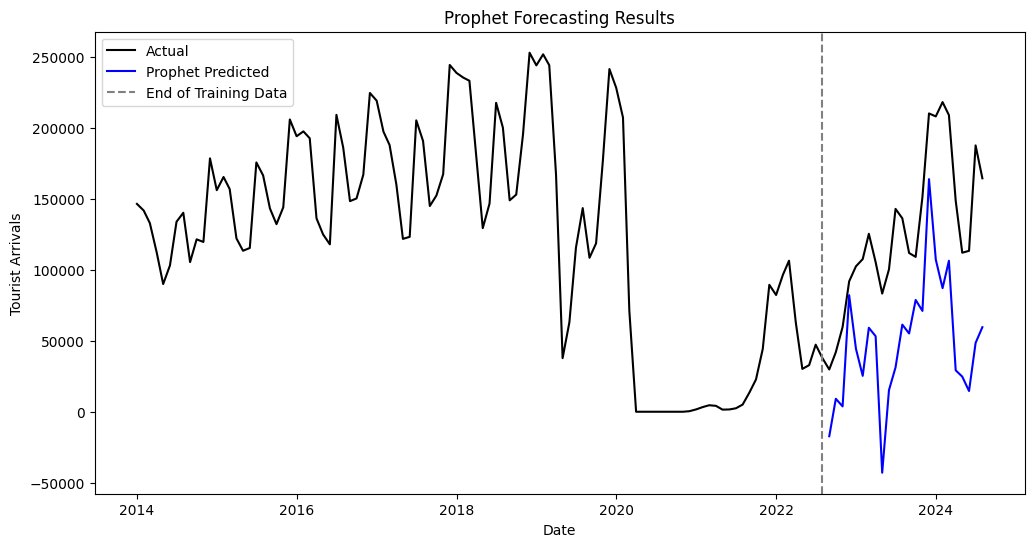

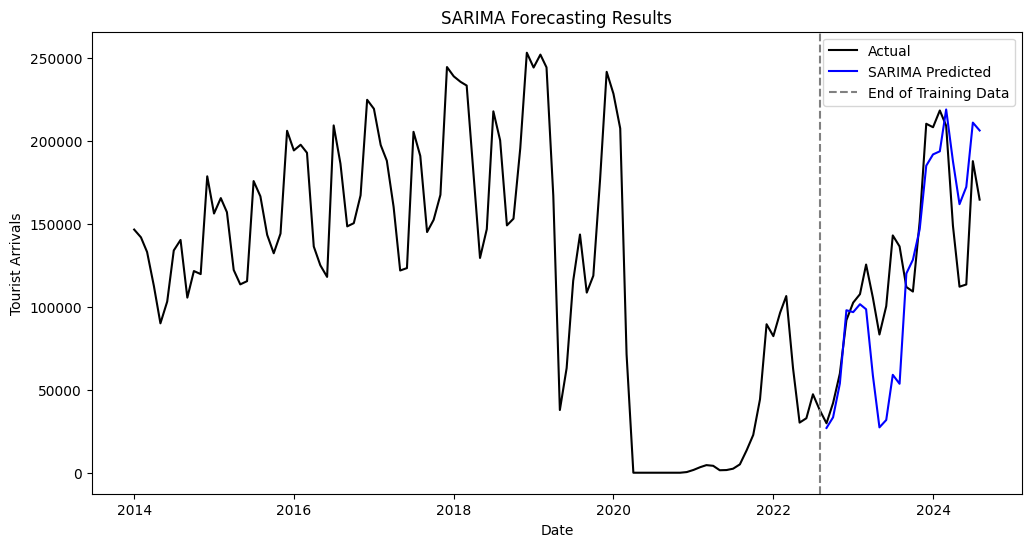

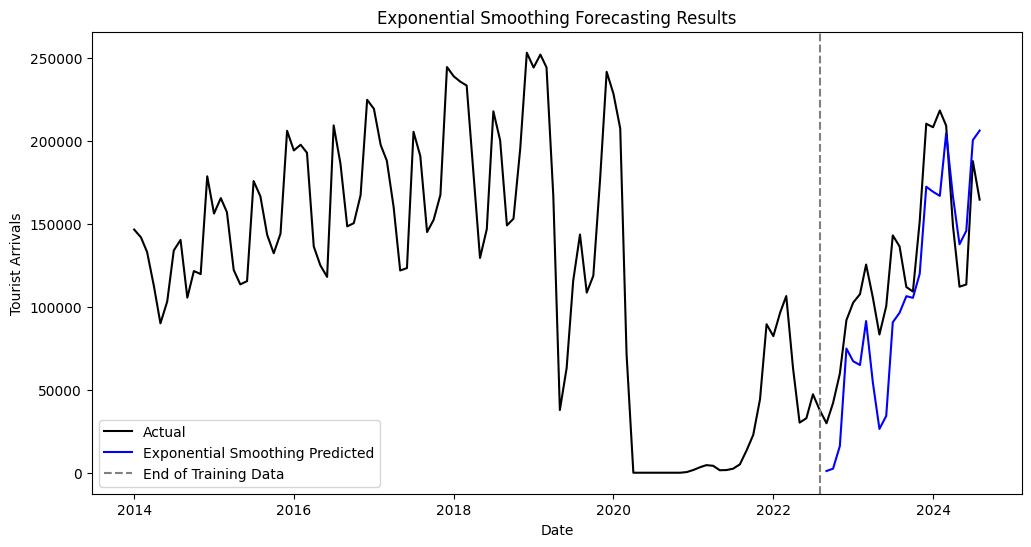

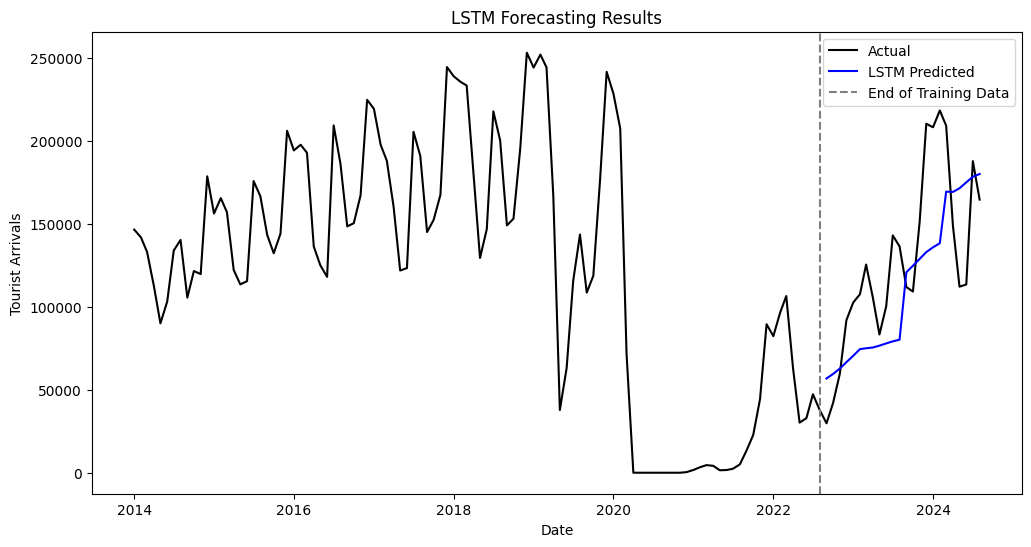

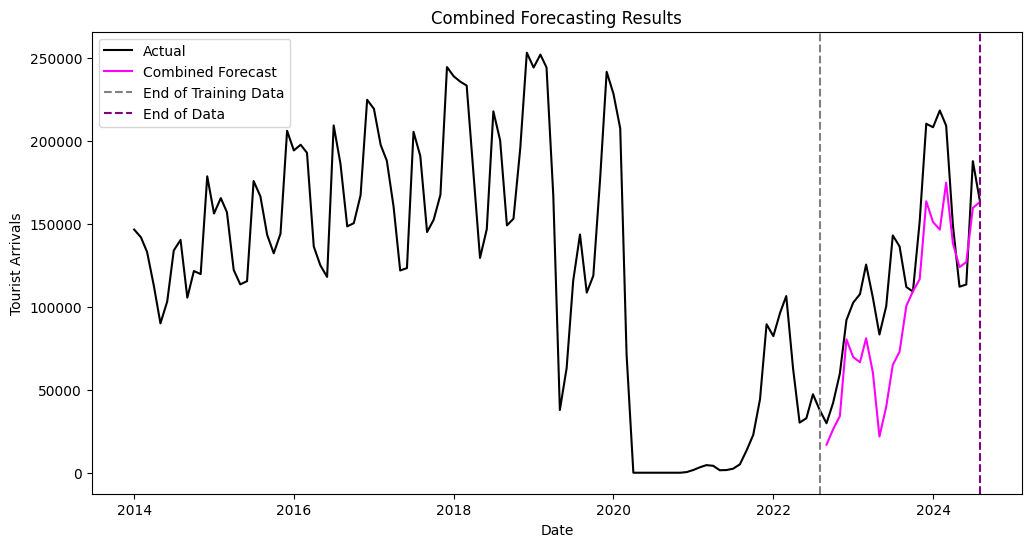

In [9]:
threshold_date = df['ds'].iloc[initial_train_size - 1]
end_of_data_date = df['ds'].max()

#Combining Multiple Models
combined_dates = prophet_cv_results['ds']

# Combine predictions averaging
combined_pred = (
    prophet_cv_results['Predicted'] +
    sarima_cv_results['Predicted'] +
    es_cv_results['Predicted'] +
    lstm_cv_results['Predicted']
) / 4

# DataFrame for combined results
combined_cv_results = pd.DataFrame({
    'ds': combined_dates,
    'Predicted': combined_pred,
    'Actual': prophet_cv_results['Actual']  # Assuming all models share the same Actuals
})

models = {
    'Prophet': prophet_cv_results,
    'SARIMA': sarima_cv_results,
    'Exponential Smoothing': es_cv_results,
    'LSTM': lstm_cv_results
}

for model_name, results in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label='Actual', color='black')
    plt.plot(results['ds'], results['Predicted'], label=f'{model_name} Predicted', color='blue')
    plt.axvline(x=threshold_date, color='gray', linestyle='--', label='End of Training Data')
    plt.title(f'{model_name} Forecasting Results')
    plt.xlabel('Date')
    plt.ylabel('Tourist Arrivals')
    plt.legend()
    plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual', color='black')
plt.plot(combined_cv_results['ds'], combined_cv_results['Predicted'], label='Combined Forecast', color='magenta')
plt.axvline(x=threshold_date, color='gray', linestyle='--', label='End of Training Data')
plt.axvline(x=end_of_data_date, color='purple', linestyle='--', label='End of Data')
plt.title('Combined Forecasting Results')
plt.xlabel('Date')
plt.ylabel('Tourist Arrivals')
plt.legend()
plt.show()

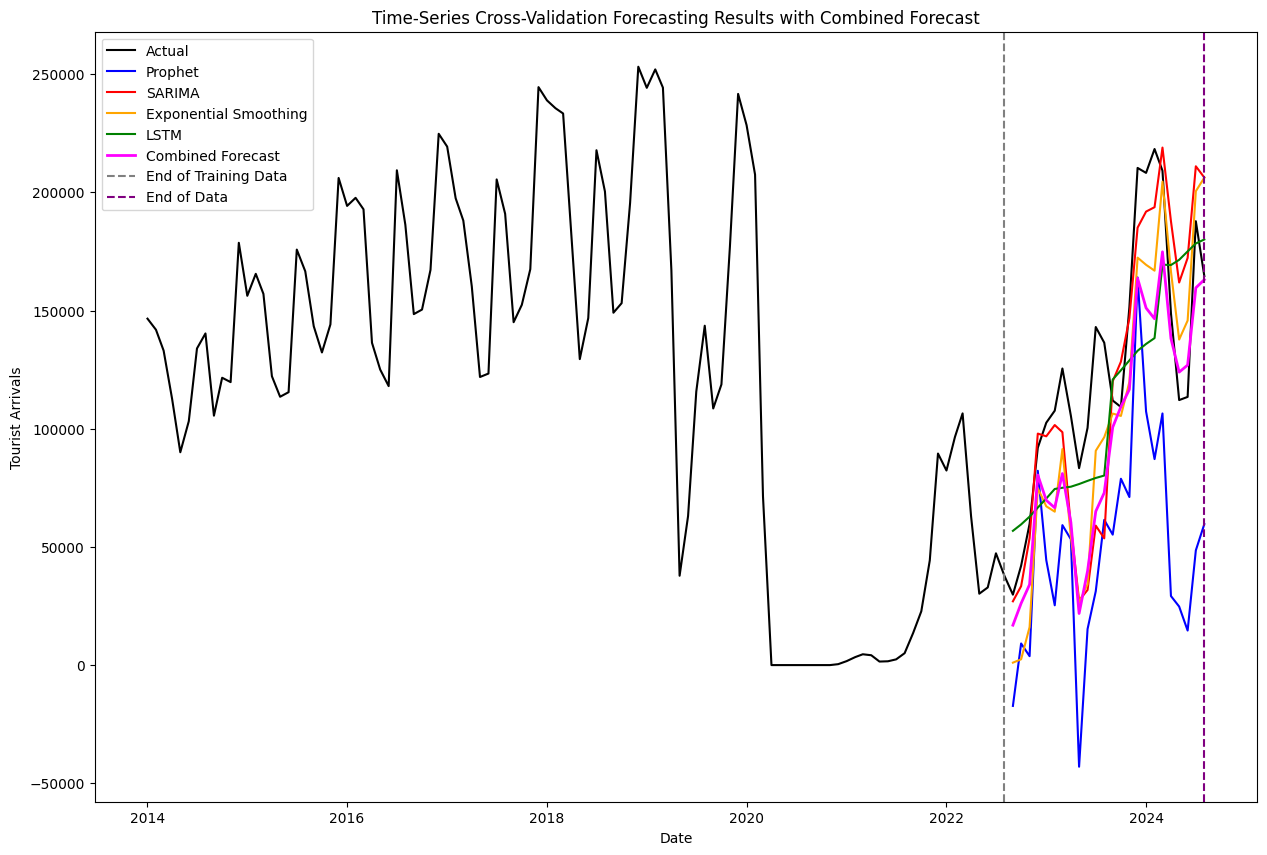

In [10]:
plt.figure(figsize=(15, 10))

plt.plot(df['ds'], df['y'], label='Actual', color='black')

# Plot individual predictions
plt.plot(prophet_cv_results['ds'], prophet_cv_results['Predicted'], label='Prophet', color='blue')
plt.plot(sarima_cv_results['ds'], sarima_cv_results['Predicted'], label='SARIMA', color='red')
plt.plot(es_cv_results['ds'], es_cv_results['Predicted'], label='Exponential Smoothing', color='orange')
plt.plot(lstm_cv_results['ds'], lstm_cv_results['Predicted'], label='LSTM', color='green')

# combined forecast
plt.plot(combined_cv_results['ds'], combined_cv_results['Predicted'], label='Combined Forecast', color='magenta', linewidth=2)

plt.axvline(x=threshold_date, color='gray', linestyle='--', label='End of Training Data')

plt.axvline(x=end_of_data_date, color='purple', linestyle='--', label='End of Data')

plt.title('Time-Series Cross-Validation Forecasting Results with Combined Forecast')
plt.xlabel('Date')
plt.ylabel('Tourist Arrivals')
plt.legend()
plt.show()

In [11]:
def calculate_mae(cv_results, model_name):
    mae = mean_absolute_error(cv_results['Actual'], cv_results['Predicted'])
    print(f"MAE for {model_name}: {mae:.2f}")
    return mae

mae_prophet = calculate_mae(prophet_cv_results, 'Prophet')
mae_sarima = calculate_mae(sarima_cv_results, 'SARIMA')
mae_es = calculate_mae(es_cv_results, 'Exponential Smoothing')
mae_lstm = calculate_mae(lstm_cv_results, 'LSTM')

combined_mae = mean_absolute_error(combined_cv_results['Actual'], combined_cv_results['Predicted'])
print(f"MAE for Combined Model: {combined_mae:.2f}")

MAE for Prophet: 79235.70
MAE for SARIMA: 30043.37
MAE for Exponential Smoothing: 33822.78
MAE for LSTM: 35437.68
MAE for Combined Model: 33960.23


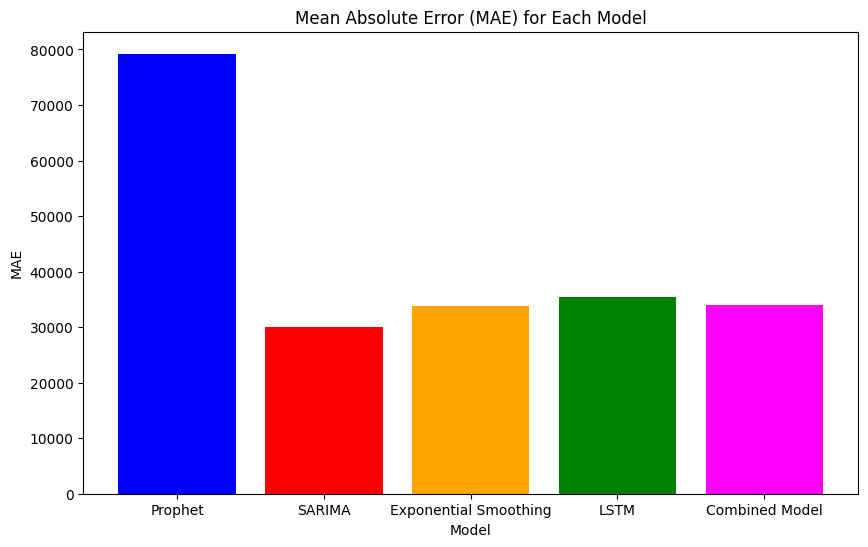

In [12]:
mae_scores = {
    'Prophet': mae_prophet,
    'SARIMA': mae_sarima,
    'Exponential Smoothing': mae_es,
    'LSTM': mae_lstm,
    'Combined Model': combined_mae
}

plt.figure(figsize=(10, 6))
plt.bar(mae_scores.keys(), mae_scores.values(), color=['blue', 'red', 'orange', 'green', 'magenta'])
plt.title('Mean Absolute Error (MAE) for Each Model')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.show()

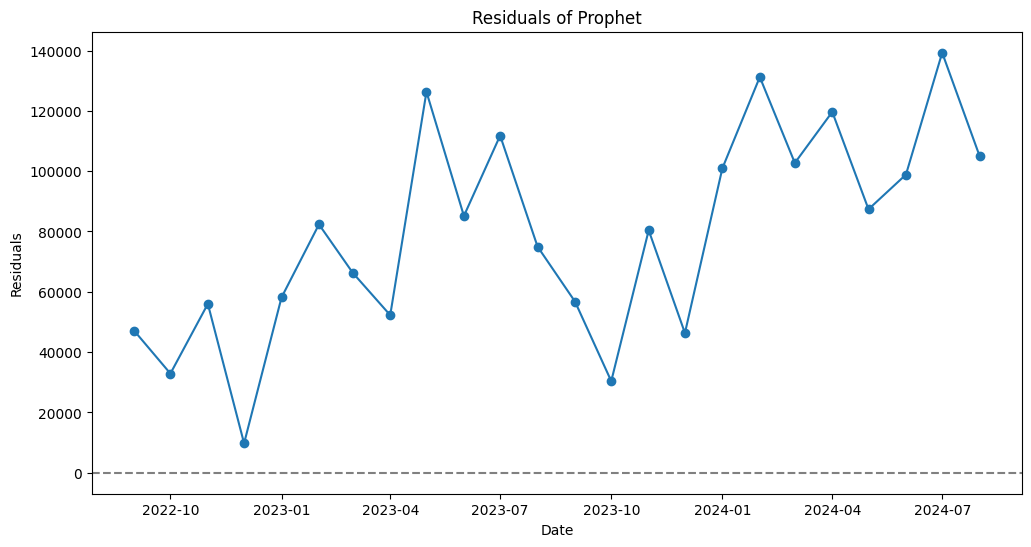

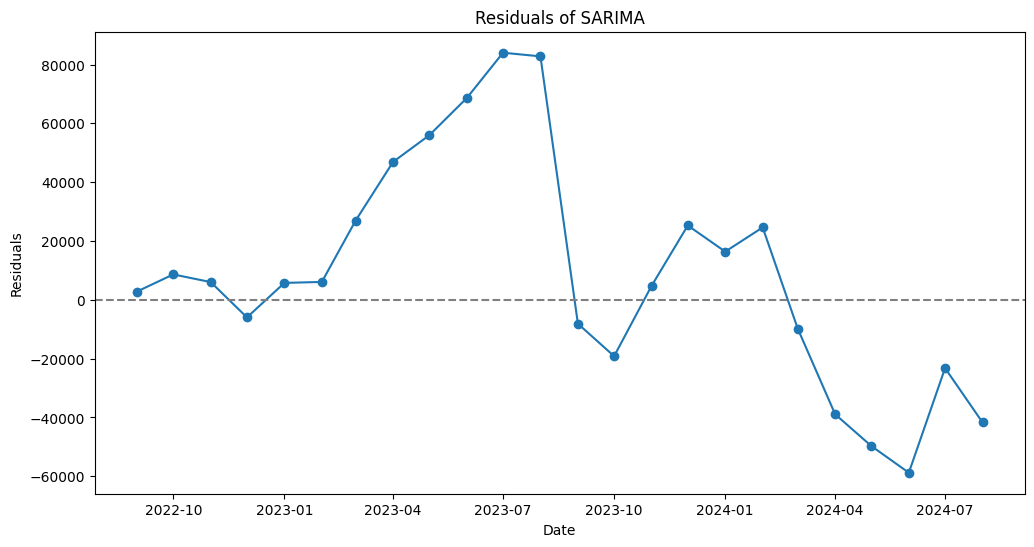

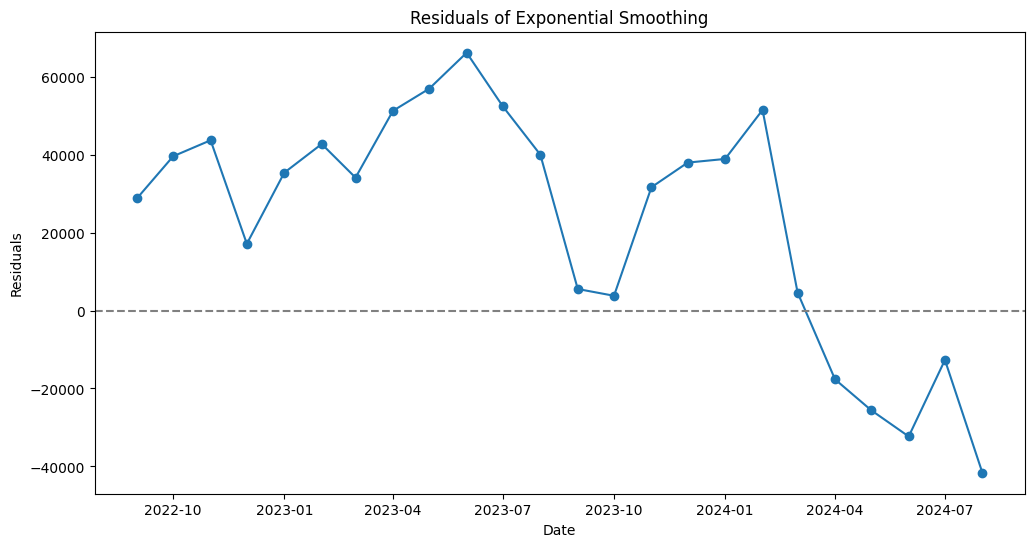

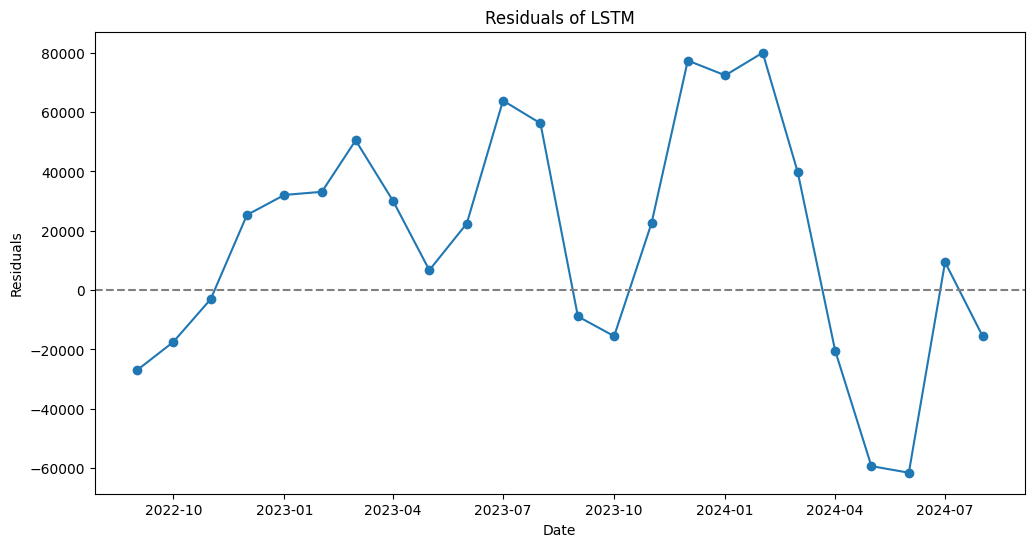

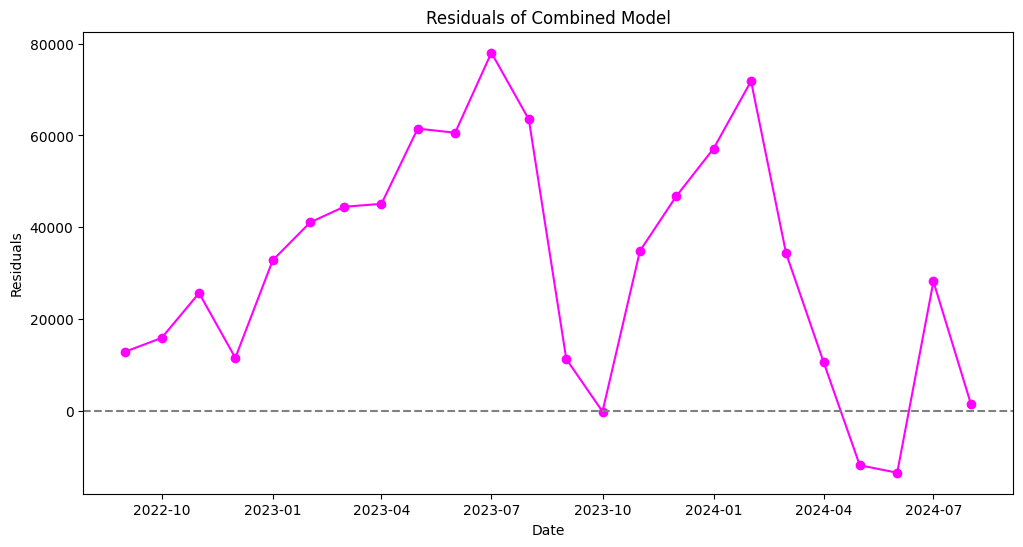

In [13]:
for model_name, results in models.items():
    residuals = results['Actual'] - results['Predicted']
    plt.figure(figsize=(12, 6))
    plt.plot(results['ds'], residuals, marker='o')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.title(f'Residuals of {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.show()

residuals_combined = combined_cv_results['Actual'] - combined_cv_results['Predicted']

plt.figure(figsize=(12, 6))
plt.plot(combined_cv_results['ds'], residuals_combined, marker='o', linestyle='-', color='magenta')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuals of Combined Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [15]:
# !sudo apt-get update
# !sudo apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic
# %pip install jupyter_core jupyter platformdirs pypandoc
!jupyter nbconvert --to pdf /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb
!jupyter nbconvert --to html /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb

[NbConvertApp] Converting notebook /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb to pdf
[NbConvertApp] Support files will be in Sri_Lankan_Tourism_Forecasting_files/
[NbConvertApp] Making directory ./Sri_Lankan_Tourism_Forecasting_files
[NbConvertApp] Writing 64569 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 705927 bytes to /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.pdf
[NbConvertApp] Converting notebook /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_Tourism_Forecasting.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConver